# 2026.01.05 DSM->訓練$\epsilon_{\theta}$
# 一維雙峰

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cpu")

sigma_dsm=1.3
batch_size=2048


In [3]:
def sample_noisy_x(batch_size, x_dim, sigma):
    mu1 = np.array([-2] + [0]*(x_dim-1), dtype=np.float32)
    mu2 = np.array([ 2] + [0]*(x_dim-1), dtype=np.float32)

    w = np.random.rand(batch_size) < 0.5
    x = np.zeros((batch_size, x_dim), dtype=np.float32)

    x[w]  = mu1 + np.random.randn(w.sum(),  x_dim).astype(np.float32)
    x[~w] = mu2 + np.random.randn((~w).sum(), x_dim).astype(np.float32)

    eps = np.random.randn(batch_size, x_dim).astype(np.float32)
    x_tilde = x + sigma * eps

    return x_tilde, eps


In [4]:
class ScoreNet(nn.Module):
    def __init__(self, x_dim, hidden, num_layers):
        super().__init__()

        layers = [nn.Linear(x_dim, hidden), nn.SiLU()]
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden, hidden))
            layers.append(nn.SiLU())
        layers.append(nn.Linear(hidden, x_dim)) 

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

model=ScoreNet(x_dim =1, hidden=64, num_layers=3).to(device)


def dsm_loss_step(x_dim, sampler):
    x_tilde_np, eps_np = sampler(batch_size, x_dim, sigma_dsm)
    x_tilde = torch.from_numpy(x_tilde_np).to(device)
    eps     = torch.from_numpy(eps_np).to(device)

    eps_pred = model(x_tilde)  ###<<<<< 預測epsilon

    target = eps
    loss = ((eps_pred - target)**2).mean()
    return loss



In [5]:
model=ScoreNet(x_dim =1, hidden=64, num_layers=3).to(device)

#### Training Loop
num_steps=5000
lr=5e-3

optimizer=optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,       
    patience=200,     
    verbose=True
)
loss_history = []

for step in range(1, num_steps+1):
    model.train()

    loss = dsm_loss_step(1, sample_noisy_x)
    

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

 
    scheduler.step(loss)

    loss_history.append(loss.item())

    if step % 200 == 0:
        print(f"step {step:4d} | loss = {loss.item():.6f} | lr = {lr:.6f}")


c:\Users\user\.conda\envs\ml_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


step  200 | loss = 0.688198 | lr = 0.005000
step  400 | loss = 0.665100 | lr = 0.005000
step  600 | loss = 0.674786 | lr = 0.005000
step  800 | loss = 0.659463 | lr = 0.005000
step 1000 | loss = 0.704799 | lr = 0.005000
step 1200 | loss = 0.718644 | lr = 0.005000
step 1400 | loss = 0.659106 | lr = 0.005000
step 1600 | loss = 0.664684 | lr = 0.005000
step 1800 | loss = 0.664590 | lr = 0.005000
step 2000 | loss = 0.685570 | lr = 0.005000
step 2200 | loss = 0.700591 | lr = 0.005000
step 2400 | loss = 0.620665 | lr = 0.005000
step 2600 | loss = 0.682515 | lr = 0.005000
step 2800 | loss = 0.612331 | lr = 0.005000
step 3000 | loss = 0.639625 | lr = 0.005000
step 3200 | loss = 0.646562 | lr = 0.005000
step 3400 | loss = 0.680552 | lr = 0.005000
step 3600 | loss = 0.672516 | lr = 0.005000
step 3800 | loss = 0.655830 | lr = 0.005000
step 4000 | loss = 0.696553 | lr = 0.005000
step 4200 | loss = 0.726141 | lr = 0.005000
step 4400 | loss = 0.693704 | lr = 0.005000
step 4600 | loss = 0.669537 | lr

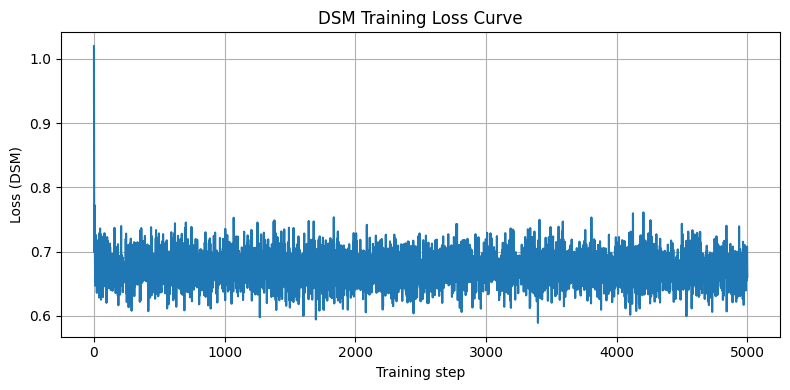

In [6]:
import matplotlib.pyplot as plt

def plot_loss_curve(loss_list):
    """
    loss_list: Python list or Tensor containing loss values for each step
    """
    plt.figure(figsize=(8,4))
    plt.plot(loss_list, linewidth=1.5)
    plt.xlabel("Training step")
    plt.ylabel("Loss (DSM)")
    plt.title("DSM Training Loss Curve")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_loss_curve(loss_history)

# 一維雙峰Sampling

In [7]:
steps = 2000
eta = 0.05

x_dim = 1
sigma_noise = 0.4  
K_traj = 20 
N_total=5000

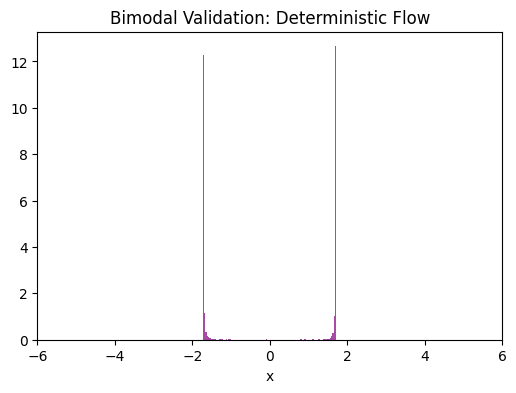

In [43]:
def langevin_sampling(model, steps, eta, N_total, sigma_final_denoise, deterministic):
    N=N_total
    model.eval()
    
    # init x
    #x = mu+torch.randn(N, x_dim).to(device) 
    #x = (torch.rand(N, 1).to(device) - 0.5) * 6  # Uniform(-3, 3)
    x_clean, _ = sample_noisy_x(batch_size=N, x_dim=1, sigma=0)
    x0 = torch.from_numpy(x_clean).to(device)
    noise_init = torch.randn_like(x0)
    x = x0 + sigma_final_denoise * noise_init
    
    sqrt_2eta = torch.sqrt(torch.tensor(2 * eta, device=device))

    with torch.no_grad():
        for k in range(steps):
            eps_pred = model(x)
            score = -eps_pred / sigma_final_denoise

            noise = torch.randn_like(x)

            if deterministic:
                # True: 只跟著 Score 走 (ODE flow)
                x = x + eta * score 
            else:
                # False: 正常 Langevin 模式
                noise = torch.randn_like(x)
                x = x + eta * score + sqrt_2eta * noise        
        # 2. (新增) 最後一步去噪 (Tweedie's Formula)
        # 原因：Langevin 採樣出來的是 "含噪分佈" (x + sigma)。
        # 如果不加這一步，你的雙峰會看起來比較 "胖" (標準差比較大)。
        # 加了這一步，點會瞬間收束到分佈的中心 (Manifold)。
        if sigma_final_denoise > 0:
            final_eps = model(x)
            x = x - sigma_final_denoise * final_eps

    return x.detach().cpu().numpy()

# === 測試雙峰 (Bimodal) ===
final_samples = langevin_sampling(
    model, 
    steps=2000, 
    eta=0.01,       
    N_total=10000,  
    sigma_final_denoise=sigma_dsm, 
    deterministic=True
)

# 畫圖檢查
plt.figure(figsize=(6, 4))
plt.hist(final_samples, bins=100, density=True, color='purple', alpha=0.7)
plt.title("Bimodal Validation: Deterministic Flow")
plt.xlim(-6, 6) # 設定範圍看清楚兩邊
plt.xlabel("x")
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_9800\3925645636.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


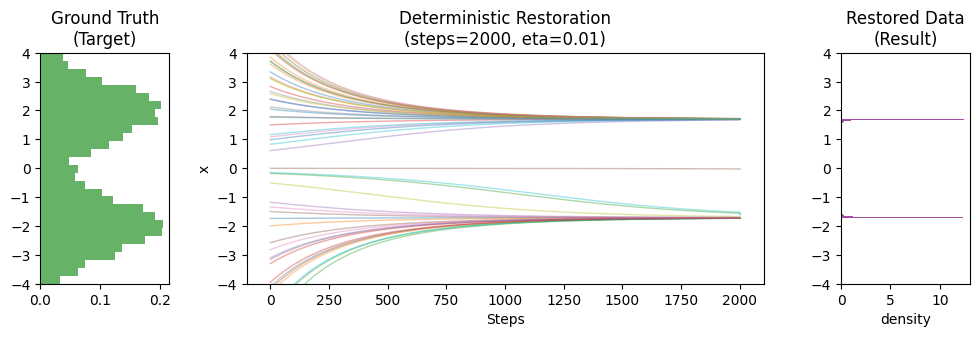

In [53]:
from matplotlib.gridspec import GridSpec

# 【修改 1】參數列補上 x_dim
def langevin_trajectories(model, steps, eta, x_dim,
                          N_total, K_traj, sigma_dsm, deterministic):
    model.eval()

    # === 1. 初始化：前向破壞過程 (Forward Process) ===
    # 取得乾淨的 Ground Truth
    x_clean, _ = sample_noisy_x(batch_size=N_total, x_dim=x_dim, sigma=0)
    x0 = torch.from_numpy(x_clean).to(device)
    
    # 為了畫圖，我們紀錄一下 "原本長怎樣" (Ground Truth)
    # 或者是紀錄 "加噪後長怎樣" (Noisy Input)，這裡我選擇紀錄 Ground Truth 當作對照
    x_init_gt = x0.detach().cpu().numpy().copy()
    
    # 手動加上訓練時強度的雜訊 -> 變成 Noisy Input
    noise_init = torch.randn_like(x0)
    x = x0 + sigma_dsm * noise_init

    # 紀錄軌跡：起點是 "加噪後的髒數據"
    traj_hist = [x[:K_traj].detach().cpu().numpy().copy()]   
    
    sqrt_2eta = torch.sqrt(torch.tensor(2*eta, device=device))
    
    # === 2. 反向修復過程 (Backward Process) ===
    for k in range(steps):
        with torch.no_grad():
            eps_pred = model(x)
            score = -eps_pred / sigma_dsm  
            
            if deterministic:
                # ODE Mode: 平滑修復
                x = x + eta * score 
            else:
                # SDE Mode: 震盪修復
                noise = torch.randn_like(x)
                x = x + eta * score + sqrt_2eta * noise

            # 紀錄
            traj_hist.append(x[:K_traj].detach().cpu().numpy().copy())
    
    # 【修改 2】最後一步 Tweedie 去噪 (讓結果更銳利)
    if sigma_dsm > 0:
        with torch.no_grad():
            final_eps = model(x)
            x = x - sigma_dsm * final_eps
            # 把這最後完美的一步也加進軌跡
            traj_hist.append(x[:K_traj].detach().cpu().numpy().copy())

    # 轉成 numpy array
    traj_hist = np.stack(traj_hist, axis=0)   
    x_final_all = x.detach().cpu().numpy().copy()
    
    return x_init_gt, x_final_all, traj_hist


def plot_3_figure(steps, eta, deterministic):
    # 呼叫函數
    x_init_gt, x_final_all, traj_hist = langevin_trajectories(
        model, steps=steps, eta=eta, x_dim=1, # 記得傳入 x_dim
        N_total=5000, K_traj=50,
        sigma_dsm=sigma_dsm, 
        deterministic=deterministic 
    )

    ####=====================
    fig = plt.figure(figsize=(12, 3))
    gs = GridSpec(1, 3, width_ratios=[1, 4, 1], wspace=0.3)

    ax_left  = fig.add_subplot(gs[0])
    ax_mid   = fig.add_subplot(gs[1])
    ax_right = fig.add_subplot(gs[2])

    # 【修改 3】左圖：顯示 Ground Truth (原本正確的答案)
    ax_left.hist(x_init_gt[:, 0], bins=40, density=True, orientation='horizontal', color='green', alpha=0.6)
    ax_left.set_title("Ground Truth\n(Target)")
    ax_left.set_ylim(-4, 4)

    # 中圖：修復軌跡
    t_axis = np.arange(traj_hist.shape[0])
    for i in range(traj_hist.shape[1]):
        ax_mid.plot(t_axis, traj_hist[:, i, 0], alpha=0.4, linewidth=1) # 透明度調低一點比較有質感

    title_str = "Deterministic Restoration" if deterministic else "Stochastic Restoration"
    ax_mid.set_title(f"{title_str}\n(steps={steps}, eta={eta})")
    ax_mid.set_xlabel("Steps")
    ax_mid.set_ylabel("x")
    ax_mid.set_ylim(-4, 4) 

    # 右圖：最終修復結果
    ax_right.hist(x_final_all[:, 0], bins=100, density=True, orientation='horizontal', color='purple', alpha=0.7)
    ax_right.set_title("Restored Data\n(Result)")
    ax_right.set_xlabel("density")
    ax_right.set_ylim(-4, 4)

    plt.tight_layout()
    plt.show()

# 執行建議：使用低溫慢燉參數 (eta=0.001)
plot_3_figure(steps=2000, eta=0.01, deterministic=True)